In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import h5py
import torch
from torch.utils.data import Dataset, DataLoader
from utils import get_Hz_ppm_conversion, zero_padding
from scipy.signal import ShortTimeFFT, windows
from pre_processing import PreProcessing
from data_augmentation import TransientMaker

In [11]:
with h5py.File('/home/leticia/Documentos/SpectroViT/MRS_dados_SpectroViT/train/p4_s02_random_1.h5') as hf:
    print(hf.keys())
    ppm = hf['ppm'][()]
    ppm = np.expand_dims(ppm, axis=0) 
    t_acq = hf['tacq'][()]
    fs = hf['fs'][()]
    t = np.arange(0, t_acq, 1 / fs)
    t = np.expand_dims(t, axis=0) 
    fids = hf['transient_specs'][()]
    fids = np.expand_dims(fids, axis=0) 
    target = hf['target_spectra'][()]
    target = np.expand_dims(target, axis=0) 

<KeysViewHDF5 ['filename', 'fs', 'larmorfreq', 'ppm', 'tacq', 'target_spectra', 'transient_specs']>


In [12]:
print(ppm.shape)
print(t.shape)
print(fs)
print(target.shape)
print(fids.shape)

(1, 2048)
(1, 2048)
2000.0
(1, 2048)
(1, 2048, 2, 40)


In [18]:
with h5py.File('../track_03_training_data.h5') as hf:
    print(hf.keys())
    ppm = hf['data_2048']['ppm'][()]
    t = hf['data_2048']['t'][()]
    target = hf['data_2048']['target_spectra'][()]
    fids = hf['data_2048']['transient_fids'][()]
    #print(hf['data_2048'].keys())

<KeysViewHDF5 ['data_2048', 'data_4096']>


In [19]:
print(ppm.shape)
print(t.shape)
print(target.shape)
print(fids.shape)

(12, 2048)
(12, 2048)
(12, 2048)
(12, 2048, 2, 160)


In [13]:
a_inv, b = get_Hz_ppm_conversion(gt_fids=fids, dwelltime=t[0,1]-t[0,0], ppm=ppm)

In [21]:
b

4.68764311213826

In [9]:
spectra_gt_fids = np.fft.fftshift(
        np.fft.fft(fids, n=fids.shape[1], axis=1), axes=1
    )
print(spectra_gt_fids.shape)
spectra_gt_diff = np.mean(spectra_gt_fids[:, :, 1,:] - spectra_gt_fids[:, :, 0,:],axis=-1)
freq = np.flip(np.fft.fftshift(np.fft.fftfreq(fids.shape[1], d=t[0,1]-t[0,0])))
print(freq)
print(freq/a_inv+b)

(1, 2048, 2, 40)
[  999.0234375   998.046875    997.0703125 ...  -998.046875   -999.0234375
 -1000.       ]
[12.50728965 12.49964582 12.49200198 ... -3.12435959 -3.13200343
 -3.13964727]


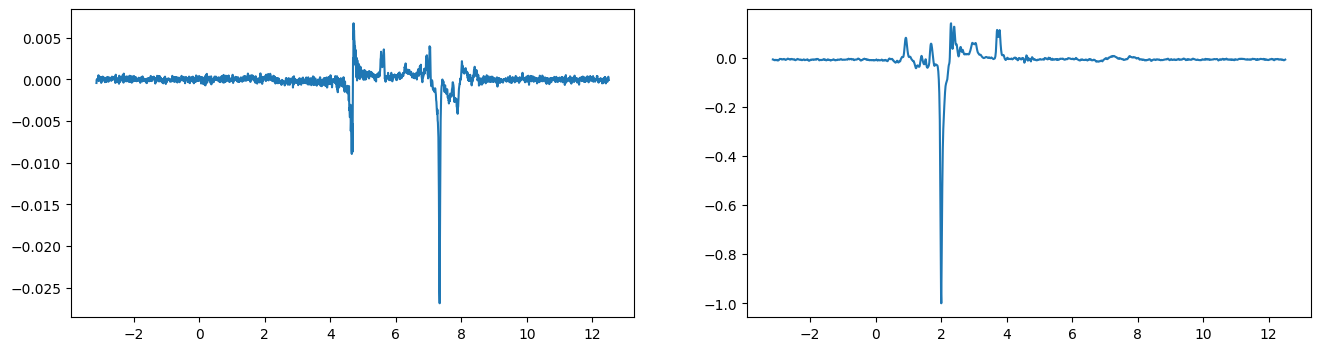

In [10]:
fig,ax = plt.subplots(1,2,figsize=(16,4))
ax[0].plot(ppm[0,:],np.flip(np.real(spectra_gt_diff[0,:])))
ax[1].plot(ppm[0,:],target[0,:]/np.max(np.abs(target[0,:])))

In [7]:
ppm

array([[12.50729  , 12.499647 , 12.4920025, ..., -3.1243587, -3.1320024,
        -3.1396465]], dtype=float32)

In [32]:
fids.shape

(1, 2048, 2, 40)

In [7]:
fid_diff = fids[0, :, 1, :] - fids[0, :, 0, :]
fid = np.mean(fid_diff, axis=1)
SFT = ShortTimeFFT(
    win=windows.hann(256,sym=True),
    hop=10,
    fs=1/(t[0, 1] - t[0, 0]),
    mfft=256,
    scale_to="magnitude",
    fft_mode="centered",
    )
t_lo, t_hi, f_lo, f_hi = SFT.extent(fid.shape[0])
print(t_lo, t_hi, f_lo, f_hi)

stft_coefficients = SFT.stft(fid)
f_spgram = np.linspace(f_lo, f_hi, 256)
t_spgram = np.linspace(t_lo, t_hi, stft_coefficients.shape[1])
ppm_spgram = b + f_spgram / a_inv
print(ppm_spgram[0],ppm_spgram[-1])

print(stft_coefficients.shape)
zero_idx = np.abs(t_spgram - 0.0).argmin()
one_idx = np.abs(t_spgram - 1.0).argmin()
t_spgram = t_spgram[zero_idx:one_idx]
stft_coefficients = stft_coefficients[:, zero_idx:one_idx]
print(stft_coefficients.shape)

# opt 1: Gab
#stft_coefficients_ordered = np.flip(stft_coefficients, axis=0)
#stft_coefficients_onesided = stft_coefficients_ordered[(ppm_spgram >= 0), :]
# opt 2:
#stft_coefficients_onesided = stft_coefficients[(ppm_spgram >= 0), :]
#stft_coefficients_onesided = np.flip(stft_coefficients_onesided, axis=0)
# opt 3:
# stft_coefficients_onesided = np.flip(stft_coefficients, axis=0)


stft_coefficients_onesided = np.flip(stft_coefficients, axis=0)
stft_coefficients_onesided_norm = stft_coefficients_onesided /(np.max(np.abs(stft_coefficients_onesided)))

-0.06 1.09 -1000.0 992.1875
-3.1731858221302467 12.419680887342837
(256, 230)
(256, 199)


In [8]:
from scipy import signal
f_gab, t_gab, stft_coefficients_gab = signal.stft(
                                        fid,
                                        fs=1/(t[0,1]-t[0,0]),
                                        nperseg=256,
                                        window='hann',
                                        noverlap=256-10,
                                        nfft=256,
                                        return_onesided=False,
                                    )

f_gab = np.concatenate([np.split(f_gab, 2)[1], np.split(f_gab, 2)[0]])
ppm_gab = 4.65 + f_gab / a_inv

stft_coefficients_ordered_gab = np.concatenate(
        [np.split(stft_coefficients_gab, 2)[1], np.split(stft_coefficients_gab, 2)[0]]
    )
stft_coefficients_ordered_gab = np.flip(stft_coefficients_ordered_gab, axis=0)
#stft_coefficients_onesided_gab = stft_coefficients_ordered_gab[(ppm_gab >= 0), :]
#stft_coefficients_onesided_norm_gab = stft_coefficients_onesided_gab/(np.max(np.abs(stft_coefficients_onesided_gab)))

stft_coefficients_onesided_norm_gab = stft_coefficients_ordered_gab/(np.max(np.abs(stft_coefficients_ordered_gab)))

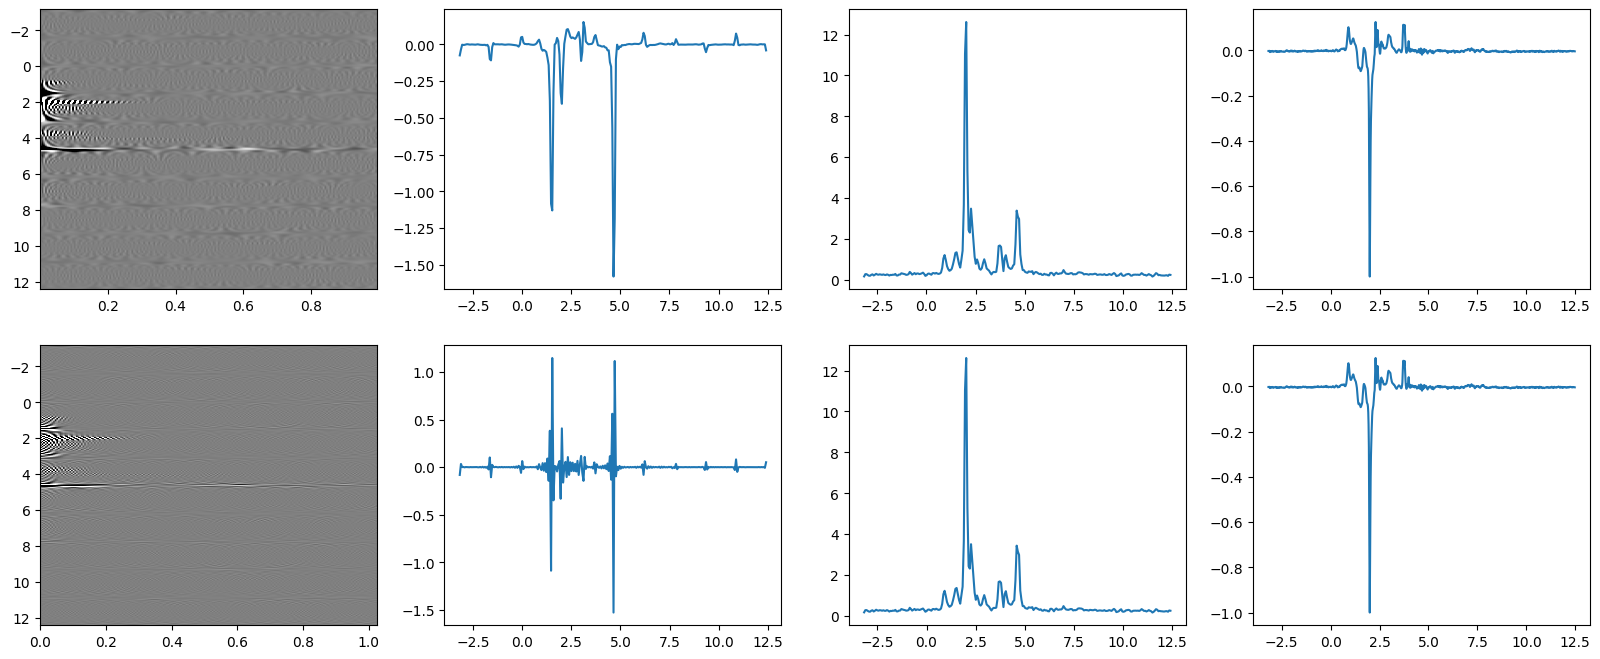

In [9]:
#teste sem cortar o ppm, só com flip

fig,ax = plt.subplots(2,4,figsize=(20,8))
ax.flat[0].imshow(np.real(stft_coefficients_onesided_norm),cmap='gray',origin='lower',
           aspect='auto', vmin = -0.04, vmax=0.04,
           extent=(t_spgram[0],t_spgram[-1],
                   ppm_spgram[-1],ppm_spgram[0]))

ax.flat[1].plot(np.flip(ppm_spgram),np.sum(np.real(stft_coefficients_onesided_norm),axis=-1))
ax.flat[2].plot(np.flip(ppm_spgram),np.sum(np.abs(np.real(stft_coefficients_onesided_norm)),axis=-1))
ax.flat[3].plot(ppm[0,:],target[0,:]/np.max(np.abs(target[0,:])))

ax.flat[4].imshow(np.real(stft_coefficients_onesided_norm_gab),cmap='gray',origin='lower',
           aspect='auto', vmin = -0.04, vmax=0.04,
           extent=(t_gab[0],t_gab[-1],
                   ppm_gab[-1],ppm_gab[0]))
ax.flat[5].plot(np.flip(ppm_gab),np.sum(np.real(stft_coefficients_onesided_norm_gab),axis=-1))
ax.flat[6].plot(np.flip(ppm_gab),np.sum(np.abs(np.real(stft_coefficients_onesided_norm_gab)),axis=-1))
ax.flat[7].plot(ppm[0,:],target[0,:]/np.max(np.abs(target[0,:])))


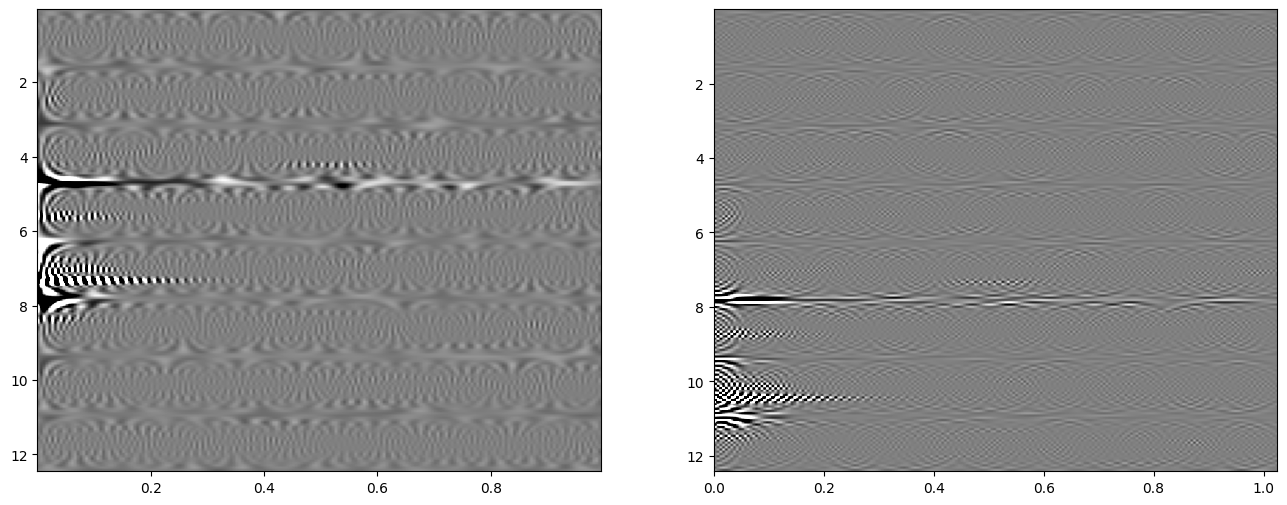

In [41]:
fig,ax = plt.subplots(1,2,figsize=(16,6))
idx_zero_ppm = np.abs(ppm_spgram - 0.0).argmin()
if ppm_spgram[idx_zero_ppm] < 0:
    idx_zero_ppm = idx_zero_ppm+1
ax[0].imshow(np.real(stft_coefficients_onesided_norm),cmap='gray',origin='lower',
           aspect='auto', vmin = -0.04, vmax=0.04,
           extent=(t_spgram[0],t_spgram[-1],
                   ppm_spgram[-1],ppm_spgram[idx_zero_ppm]))

idx_zero_ppm_gab = np.abs(ppm_gab - 0.0).argmin()
if ppm_gab[idx_zero_ppm_gab] < 0:
    idx_zero_ppm_gab = idx_zero_ppm_gab+1
ax[1].imshow(np.real(stft_coefficients_onesided_norm_gab),cmap='gray',origin='lower',
           aspect='auto', vmin = -0.04, vmax=0.04,
           extent=(t_gab[0],t_gab[-1],
                   ppm_gab[-1],ppm_gab[idx_zero_ppm_gab]))

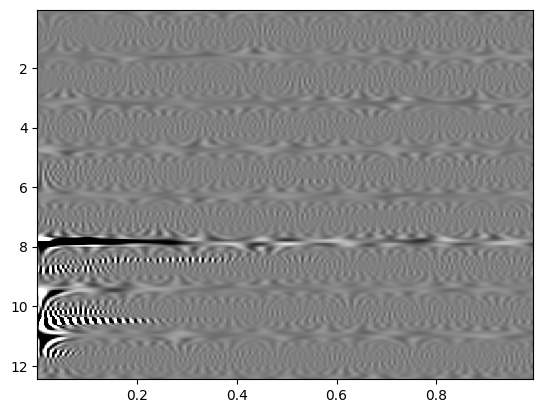

In [45]:
idx_zero_ppm = np.abs(ppm_spgram - 0.0).argmin()
if ppm_spgram[idx_zero_ppm] < 0:
    idx_zero_ppm = idx_zero_ppm+1
plt.imshow(np.real(stft_coefficients_onesided_norm),cmap='gray',origin='lower',
           aspect='auto', vmin = -0.04, vmax=0.04,
           extent=(t_spgram[0],t_spgram[-1],
                   ppm_spgram[-1],ppm_spgram[idx_zero_ppm]))

(1.0, 4.0)

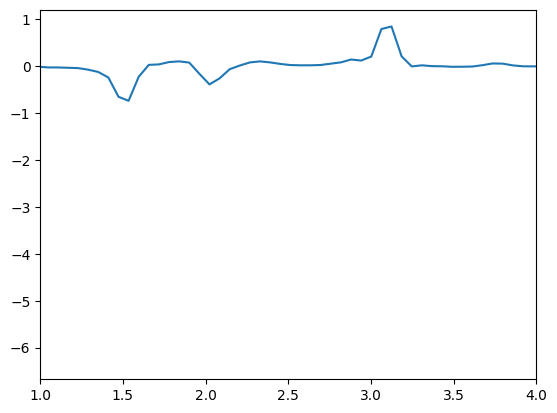

In [18]:
plt.plot(np.flip(ppm_spgram[idx_zero_ppm:]),np.sum(np.real(stft_coefficients_onesided_norm),axis=-1))
plt.xlim(1,4)

(1.0, 4.0)

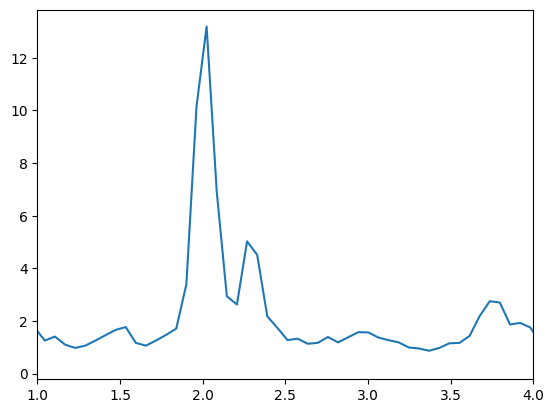

In [19]:
plt.plot(np.flip(ppm_spgram[idx_zero_ppm:]),np.sum(np.abs(np.real(stft_coefficients_onesided_norm)),axis=-1))
plt.xlim(1,4)


In [19]:
import os
from utils import ReadDatasets
"""
class DatasetRealDataSeparateFiles(Dataset):
    def __init__(self,
        path_data,
        augment_with_noise,
        start=None,
        end=None,
        linear_shift=None,
        hop_size=None,
        window_size=None,
        window=None,
        **kwargs_augment_by_noise) -> None:


        self.path_data = path_data
        self.augment_with_noise = augment_with_noise
        self.random_augment = kwargs_augment_by_noise

        file_list = sorted(os.listdir(self.path_data))
        if start is not None and end is not None:
            self.file_list = file_list[start:end]
        elif start is not None and end is None:
            self.file_list = file_list[start:]
        elif start is None and end is not None:
            self.file_list = file_list[:end]
        else:
            self.file_list = file_list

        path_sample = os.path.join(self.path_data, self.file_list[0])
        transients, target_spectrum, ppm, fs, tacq, larmorfreq = (
            ReadDatasets.read_h5_complete(path_sample)
        )
        transients = np.expand_dims(transients, axis=0) 
        ppm = np.expand_dims(ppm,axis=0)

        self.fs = fs

        a_inv, b = get_Hz_ppm_conversion(
                gt_fids=transients, dwelltime=1/self.fs, ppm=ppm
                )
        if (round(a_inv) == round(larmorfreq)) and linear_shift == None:
            self.larmorfreq = larmorfreq
            self.linear_shift = b
        elif (round(a_inv) != round(larmorfreq)) and linear_shift == None:
            raise ValueError('no match between larmorfreq given and calculated. given: '+str(round(larmorfreq))+
                             'calculated: '+str(round(a_inv)))
        elif linear_shift != None:
            self.larmorfreq = larmorfreq
            self.linear_shift = linear_shift
        
        if hop_size is not None and window_size is not None and window is not None:
            if window.shape[0] == window_size:
                self.SFT = ShortTimeFFT(
                    win=window,
                    hop=hop_size,
                    fs=self.fs,
                    mfft=window_size,
                    scale_to="magnitude",
                    fft_mode="centered",
                )
                self.hop_size = hop_size
                self.window_size = window_size
                self.window = window
            else:
                self.SFT = None
                self.hop_size = None
                self.window_size = None
                self.window = None
        else:
            self.SFT = None
            self.hop_size = None
            self.window_size = None
            self.window = None
        

    def __len__(self) -> int:
        return len(self.file_list)

    def _get_interval_method_augment(self, key):
        if key in self.random_augment.keys():
            max = self.random_augment[key]["noise_level_base"]["max"] + 1
            min = self.random_augment[key]["noise_level_base"]["min"]
            noise_level_base = np.random.randint(min, max)
            max = self.random_augment[key]["noise_level_scan_var"]["max"] + 1
            min = self.random_augment[key]["noise_level_scan_var"]["min"]
            noise_level_scan_var = np.random.randint(min, max)
            return noise_level_base, noise_level_scan_var
        else:
            return None,None
        
    def _modulate_value(self,decimal_value, vector):
        max_value = np.max(np.abs(vector))
        order_of_magnitude = int(np.floor(np.log10(max_value))) if max_value != 0 else 0
        if order_of_magnitude == 0 or order_of_magnitude==1:
            modulated_value = decimal_value
        else:
            modulated_value = decimal_value * 10**(order_of_magnitude-1)
        return modulated_value
    

    def __getitem__(
        self, idx: int
    ) -> (torch.Tensor, torch.Tensor, torch.Tensor, float, str):

        path_sample = os.path.join(self.path_data, self.file_list[idx])
        filename = os.path.basename(path_sample)
        noise_amplitude_base, noise_amplitude_var = self._get_interval_method_augment("amplitude")
        noise_frequency_base, noise_frequency_var = self._get_interval_method_augment("frequency")
        noise_phase_base, noise_phase_var = self._get_interval_method_augment("phase")

        transients, target_spectrum, ppm, fs, tacq, larmorfreq = (
            ReadDatasets.read_h5_complete(path_sample)
        )
        transients = np.expand_dims(transients, axis=0) 

        constant_factor = np.max(np.abs(target_spectrum))
        target_spectrum /= constant_factor

        fig,ax = plt.subplots(1,2,figsize=(16,6))
        ax[0].plot(np.real(transients[0,:,0,0]))
        ax[1].plot(np.real(transients[0,1800:,0,0]))
        plt.savefig('fids_before_noise_'+str(idx))
        plt.close()

        t = np.arange(0, tacq, 1 /self.fs)
        t = np.expand_dims(t, axis=0) 
        if self.augment_with_noise is True:
            transientmkr = TransientMaker(fids=transients, t=t, create_transients=False)
            if noise_amplitude_base is not None and noise_amplitude_var is not None:
                noise_amplitude_base_mod = self._modulate_value(noise_amplitude_base, np.real(transients[0,int(ppm.shape[0]/4):,:,:]))
                noise_amplitude_var_mod = self._modulate_value(noise_amplitude_var, np.real(transients[0,int(ppm.shape[0]/4):,:,:]))
                transientmkr.add_random_amplitude_noise(noise_level_base=noise_amplitude_base_mod, 
                                                        noise_level_scan_var=noise_amplitude_var_mod)
            if noise_frequency_base is not None and noise_frequency_var is not None:
                transientmkr.add_random_frequency_noise(noise_level_base=noise_frequency_base, 
                                                        noise_level_scan_var=noise_frequency_var)
            if noise_phase_base is not None and noise_phase_var is not None:
                transientmkr.add_random_phase_noise(noise_level_base=noise_phase_base, 
                                                        noise_level_scan_var=noise_phase_var)
            transients = transientmkr.fids

        fig,ax = plt.subplots(1,2,figsize=(16,6))
        ax[0].plot(np.real(transients[0,:,0,0]))
        ax[1].plot(np.real(transients[0,1800:,0,0]))
        ax[0].set_title('amp:'+str(noise_amplitude_base_mod)+'+-'+str(noise_amplitude_var_mod)+'\n'+
                        'freq:'+str(noise_frequency_base)+'+-'+str(noise_frequency_var)+'\n'+
                        'phase:'+str(noise_phase_base)+'+-'+str(noise_phase_var))
        plt.savefig('fids_after_noise_'+str(idx))
        plt.close()

        spectrogram1 = PreProcessing.spgram_channel(
            fid_off=transients[0,:,0,0:14],
            fid_on=transients[0,:,1,0:14],
            fs=self.fs,
            larmorfreq=self.larmorfreq,
            linear_shift=self.linear_shift,
            hop_size=self.hop_size,
            window_size=self.window_size,
            window=self.window,
            SFT=self.SFT,
        )

        spectrogram2 = PreProcessing.spgram_channel(
            fid_off=transients[0,:,0,14:27],
            fid_on=transients[0,:,1,14:27],
            fs=self.fs,
            larmorfreq=self.larmorfreq,
            linear_shift=self.linear_shift,
            hop_size=self.hop_size,
            window_size=self.window_size,
            window=self.window,
            SFT=self.SFT,
        )

        spectrogram3 = PreProcessing.spgram_channel(
            fid_off=transients[0,:,0,27:40],
            fid_on=transients[0,:,1,27:40],
            fs=self.fs,
            larmorfreq=self.larmorfreq,
            linear_shift=self.linear_shift,
            hop_size=self.hop_size,
            window_size=self.window_size,
            window=self.window,
            SFT=self.SFT,
        )

        spectrogram1 = zero_padding(spectrogram1)
        spectrogram1 = spectrogram1[np.newaxis, ...]
        spectrogram1 = torch.from_numpy(spectrogram1.real)

        spectrogram2 = zero_padding(spectrogram2)
        spectrogram2 = spectrogram2[np.newaxis, ...]
        spectrogram2 = torch.from_numpy(spectrogram2.real)

        spectrogram3 = zero_padding(spectrogram3)
        spectrogram3 = spectrogram3[np.newaxis, ...]
        spectrogram3 = torch.from_numpy(spectrogram3.real)

        target_spectrum = torch.from_numpy(target_spectrum)
        ppm = torch.from_numpy(ppm)

        three_channels_spectrogram = torch.concat(
            [spectrogram1, spectrogram2, spectrogram3]
        )

        return (
            three_channels_spectrogram.type(torch.FloatTensor),
            target_spectrum.type(torch.FloatTensor),
            ppm,
            constant_factor,
            filename,
            transients
        )
"""

class DatasetSpgramRealData(Dataset):
    def __init__(
        self,
        path_data,
        augment_with_noise,
        augment_with_idx_repetition,
        start=None,
        end=None,
        fs=None,
        larmorfreq=None,
        linear_shift=None,
        hop_size=None,
        window_size=None,
        window=None,
        qntty_to_augment_by_idx=None,
        **kwargs_augment_by_noise
    ):

        self.path_data = path_data
        self.augment_with_noise = augment_with_noise
        self.augment_with_idx_repetition = augment_with_idx_repetition
        self.get_item_first_time = True
        self.random_augment = kwargs_augment_by_noise

        with h5py.File(self.path_data) as hf:
            ppm = hf['ppm'][()][:1]
            t = np.empty((1,ppm.shape[-1]))
            hf["t"].read_direct(t,source_sel=np.s_[0:1])
            fids = hf['transient_fids'][()][:1]
            self.fids_transient_qntty = fids.shape[-1]
            total_qntty = len(hf['transient_fids'])

        if start is not None and end is not None:
            self.start_pos = start
            self.end_pos = end
        elif start is not None and end is None:
            self.start_pos = start
            self.end_pos = total_qntty
        elif start is None and end is not None:
            self.start_pos = 0
            self.end_pos = end
        else:
            self.start_pos = 0
            self.end_pos = total_qntty

        if self.augment_with_idx_repetition is True and qntty_to_augment_by_idx is not None:
            self.qntty_to_augment_by_idx = qntty_to_augment_by_idx
        elif self.augment_with_idx_repetition is True and qntty_to_augment_by_idx is None:
            self.qntty_to_augment_by_idx = 200
        else:
            self.qntty_to_augment_by_idx = None

        if fs == None:
            dwelltime = t[0, 1] - t[0, 0]
            self.fs = 1 / dwelltime
        else:
            self.fs = fs

        if larmorfreq == None or linear_shift == None:
            a_inv, b = get_Hz_ppm_conversion(
                gt_fids=fids, dwelltime=1 / self.fs, ppm=ppm
            )
        if larmorfreq == None and linear_shift == None:
            self.larmorfreq = a_inv
            self.linear_shift = b
        elif larmorfreq == None and linear_shift != None:
            self.larmorfreq = a_inv
            self.linear_shift = linear_shift
        elif larmorfreq != None and linear_shift == None:
            self.larmorfreq = larmorfreq
            self.linear_shift = b
        else:
            self.larmorfreq = larmorfreq
            self.linear_shift = linear_shift

        if hop_size is not None and window_size is not None and window is not None:
            if window.shape[0] == window_size:
                self.SFT = ShortTimeFFT(
                    win=window,
                    hop=hop_size,
                    fs=self.fs,
                    mfft=window_size,
                    scale_to="magnitude",
                    fft_mode="centered",
                )
                self.hop_size = hop_size
                self.window_size = window_size
                self.window = window
            else:
                self.SFT = None
                self.hop_size = None
                self.window_size = None
                self.window = None
        else:
            self.SFT = None
            self.hop_size = None
            self.window_size = None
            self.window = None
        
        if self.augment_with_idx_repetition is True:
            self.idx_data = np.empty(self.qntty_to_augment_by_idx * (self.end_pos - self.start_pos), dtype="int")
            idx_counter = 0
            for i in range(self.start_pos, self.end_pos):
                for j in range(self.qntty_to_augment_by_idx):
                    self.idx_data[self.qntty_to_augment_by_idx * idx_counter + j] = i
                idx_counter=idx_counter+1
        else:
            self.idx_data = np.arange(self.start_pos, self.end_pos)

    def __len__(self) -> int:
        return self.idx_data.shape[0]
    
    def _get_interval_method_augment(self, key):
        if key in self.random_augment.keys():
            max = self.random_augment[key]["noise_level_base"]["max"] + 1
            min = self.random_augment[key]["noise_level_base"]["min"]

            noise_level_base = np.random.randint(min, max)

            max = self.random_augment[key]["noise_level_scan_var"]["max"] + 1
            min = self.random_augment[key]["noise_level_scan_var"]["min"]

            noise_level_scan_var = np.random.randint(min, max)

            return noise_level_base, noise_level_scan_var
        else:
            return None,None
    
    def _modulate_value(self,decimal_value, vector):
        max_value = np.max(np.abs(vector))
        order_of_magnitude = int(np.floor(np.log10(max_value))) if max_value != 0 else 0
        if order_of_magnitude == 0 or order_of_magnitude==1:
            modulated_value = decimal_value
        else:
            modulated_value = decimal_value * 10**(order_of_magnitude-1)
        return modulated_value
        
    def _get_random_transients(self,high):
        idx_transient_samples = np.random.randint(low=0,high=high,size=40)
        return idx_transient_samples

    def __getitem__(
        self, idx: int
    ) -> (torch.Tensor, torch.Tensor, torch.Tensor, float, str):

        filename = self.path_data
        idx_in_file = self.idx_data[idx]
        noise_amplitude_base, noise_amplitude_var = self._get_interval_method_augment("amplitude")
        noise_frequency_base, noise_frequency_var = self._get_interval_method_augment("frequency")
        noise_phase_base, noise_phase_var = self._get_interval_method_augment("phase")

        with h5py.File(self.path_data) as hf:
            ppm = hf["ppm"][()][idx_in_file]
            t = np.empty((1,ppm.shape[-1]))
            hf['t'].read_direct(t,source_sel=np.s_[idx_in_file : idx_in_file + 1])
            
            aug_fids = np.empty((1,ppm.shape[-1],2,40),dtype='complex128')
            spectrum = np.empty((ppm.shape[-1]),dtype='float64')
            hf['target_spectra'].read_direct(spectrum,source_sel=np.s_[idx_in_file])
            if self.fids_transient_qntty > 40:
                fid_aux = np.empty((1,ppm.shape[-1],2,self.fids_transient_qntty),dtype='complex128')
                hf['transient_fids'].read_direct(fid_aux,source_sel=np.s_[idx_in_file : idx_in_file + 1])
            else:
                hf['transient_fids'].read_direct(aug_fids,source_sel=np.s_[idx_in_file : idx_in_file + 1])

        if self.fids_transient_qntty > 40:
            if self.augment_with_idx_repetition is True:
                idx_transient_samples = self._get_random_transients(high=self.fids_transient_qntty)
                np.savetxt('selected_transients_'+str(idx)+'_'+str(idx_in_file),idx_transient_samples,fmt='%.1e')
                for i in range(len(idx_transient_samples)):
                    aug_fids[0,:,:,i] = fid_aux[0,:,:,idx_transient_samples[i]]
            else:
                aug_fids = fid_aux[:,:,:,:40]
        
        fig,ax = plt.subplots(1,2,figsize=(16,6))
        ax[0].plot(np.real(aug_fids[0,:,0,0]))
        ax[1].plot(np.real(aug_fids[0,1800:,0,0]))
        plt.savefig('fids_before_noise_'+str(idx)+'_'+str(idx_in_file))
        plt.close()

        if self.augment_with_noise is True:
            transientmkr = TransientMaker(fids=aug_fids, t=t, create_transients=False)
            if noise_amplitude_base is not None and noise_amplitude_var is not None:
                noise_amplitude_base_mod = self._modulate_value(noise_amplitude_base, np.real(aug_fids[0,int(ppm.shape[0]/4):,:,:]))
                noise_amplitude_var_mod = self._modulate_value(noise_amplitude_var, np.real(aug_fids[0,int(ppm.shape[0]/4):,:,:]))
                transientmkr.add_random_amplitude_noise(noise_level_base=noise_amplitude_base_mod, 
                                                        noise_level_scan_var=noise_amplitude_var_mod)
            if noise_frequency_base is not None and noise_frequency_var is not None:
                transientmkr.add_random_frequency_noise(noise_level_base=noise_frequency_base, 
                                                        noise_level_scan_var=noise_frequency_var)
            if noise_phase_base is not None and noise_phase_var is not None:
                transientmkr.add_random_phase_noise(noise_level_base=noise_phase_base, 
                                                        noise_level_scan_var=noise_phase_var)
            aug_fids = transientmkr.fids
        
        fig,ax = plt.subplots(1,2,figsize=(16,6))
        ax[0].plot(np.real(aug_fids[0,:,0,0]))
        ax[1].plot(np.real(aug_fids[0,1800:,0,0]))
        ax[0].set_title('amp:'+str(noise_amplitude_base_mod)+'+-'+str(noise_amplitude_var_mod)+'\n'+
                        'freq:'+str(noise_frequency_base)+'+-'+str(noise_frequency_var)+'\n'+
                        'phase:'+str(noise_phase_base)+'+-'+str(noise_phase_var))
        plt.savefig('fids_after_noise_'+str(idx)+'_'+str(idx_in_file))
        plt.close()

        spectrogram1 = PreProcessing.spgram_channel(
            fid_off=aug_fids[0, :, 0, 0:14],
            fid_on=aug_fids[0, :, 1, 0:14],
            fs=self.fs,
            larmorfreq=self.larmorfreq,
            linear_shift=self.linear_shift,
            hop_size=self.hop_size,
            window_size=self.window_size,
            window=self.window,
            SFT=self.SFT,
        )

        spectrogram2 = PreProcessing.spgram_channel(
            fid_off=aug_fids[0, :, 0, 14:27],
            fid_on=aug_fids[0, :, 1, 14:27],
            fs=self.fs,
            larmorfreq=self.larmorfreq,
            linear_shift=self.linear_shift,
            hop_size=self.hop_size,
            window_size=self.window_size,
            window=self.window,
            SFT=self.SFT,
        )

        spectrogram3 = PreProcessing.spgram_channel(
            fid_off=aug_fids[0, :, 0, 27:40],
            fid_on=aug_fids[0, :, 1, 27:40],
            fs=self.fs,
            larmorfreq=self.larmorfreq,
            linear_shift=self.linear_shift,
            hop_size=self.hop_size,
            window_size=self.window_size,
            window=self.window,
            SFT=self.SFT,
        )

        if self.get_item_first_time == True:
            print("Generating Spectrograms of size: ", spectrogram1.shape)

        spectrogram1 = zero_padding(spectrogram1)
        spectrogram1 = spectrogram1[np.newaxis, ...]
        if self.get_item_first_time == True:
            print("Zero padded to shape: ", spectrogram1.shape)
            self.get_item_first_time = False
        spectrogram1 = torch.from_numpy(np.real(spectrogram1))

        spectrogram2 = zero_padding(spectrogram2)
        spectrogram2 = spectrogram2[np.newaxis, ...]
        spectrogram2 = torch.from_numpy(np.real(spectrogram2))

        spectrogram3 = zero_padding(spectrogram3)
        spectrogram3 = spectrogram3[np.newaxis, ...]
        spectrogram3 = torch.from_numpy(np.real(spectrogram3))
        three_channels_spectrogram = torch.concat(
            [spectrogram1, spectrogram2, spectrogram3]
        )

        constant_factor = np.max(np.abs(spectrum))
        spectra_norm = spectrum / constant_factor
        target_spectrum = torch.from_numpy(np.real(spectra_norm))
        ppm = torch.from_numpy(ppm)

        return (
            three_channels_spectrogram.type(torch.FloatTensor),
            target_spectrum.type(torch.FloatTensor),
            ppm,
            constant_factor,
            filename,
            aug_fids
        )


In [20]:
"""
dataset =  DatasetRealDataSeparateFiles(path_data='../dataset_spectrovit_only_phillips/train',
        augment_with_noise=True,
        start=0,
        end=7,
        hop_size=10,
        window_size=256,
        window=windows.hann(256,sym=True),
        **{'amplitude':{'noise_level_base':{'max':10,'min':2},
                                    'noise_level_scan_var':{'max':2,'min':0}},
                                'frequency':{'noise_level_base':{'max':6,'min':2},
                                    'noise_level_scan_var':{'max':2,'min':0}},
                                'phase':{'noise_level_base':{'max':6,'min':2},
                                     'noise_level_scan_var':{'max':2,'min':0}}})
"""

dataset = DatasetSpgramRealData(path_data='../dataset_tracks2and3_training_data.h5',
        augment_with_noise=True,
        augment_with_idx_repetition=True,
        start=0,
        end=7,
        hop_size=10,
        window_size=256,
        window=windows.hann(256,sym=True),
        qntty_to_augment_by_idx=2,
        **{'amplitude':{'noise_level_base':{'max':10,'min':2},
                                    'noise_level_scan_var':{'max':2,'min':0}},
                                'frequency':{'noise_level_base':{'max':6,'min':2},
                                    'noise_level_scan_var':{'max':2,'min':0}},
                                'phase':{'noise_level_base':{'max':6,'min':2},
                                     'noise_level_scan_var':{'max':2,'min':0}}})

In [21]:
dataloader = DataLoader(dataset=dataset,batch_size=10,shuffle=False)
counter=0
for batch in dataloader:
    input_, target_, ppm_, _, _, fids_= batch[0], batch[1], batch[2], batch[3], batch[4], batch[5]
    counter=counter+1
    break

Generating Spectrograms of size:  (204, 199)
Zero padded to shape:  (1, 224, 224)


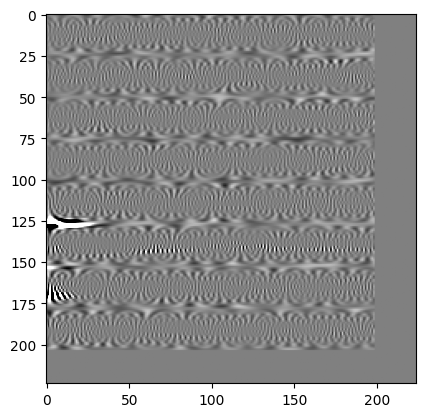

In [15]:
plt.imshow(input_[3,0,:,:].detach().numpy(),cmap='gray',vmin=-0.04,vmax=0.04)